# SETUP

In [36]:
# Installing dependencies
!pip install tensorflow==2.9.1 tensorflow-gpu==2.9.1 opencv-python matplotlib

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [34]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
# Avoid out of memory errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimetnal.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# COLLECT POSITIVES AND ANCHORS


In [6]:
#Uncompress Tar GZ Labelled  Faces in the Wild Dataset
!tar -xf lfw.tgz

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
# Import uuid library to generate image names
import uuid

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Cut down frame to 250x250
    frame = frame[120:120+250, 200:200+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out anchor name
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out positive name
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# Realase the webcam        
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# DATA AUGMENTATION

In [9]:
def data_aug(img):
    
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta = 0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [10]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [11]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# LOAD AND PREPROCESS IMAGES 

In [35]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [36]:
def preprocess(file_path):
    
    # read in image from file_path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (105,105))
    # scale image to be between 0 and 1
    img = img/255.0
    
    # return image
    return img

In [37]:
# Create labelled dataset
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [38]:
samples = data.as_numpy_iterator()

In [39]:
samples.next()

(b'data\\anchor\\a1100d26-5935-11ed-af99-f47b09d8627d.jpg',
 b'data\\positive\\838396ab-5933-11ed-851f-f47b09d8627d.jpg',
 1.0)

In [40]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [41]:
# Buid dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 10000)

In [42]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [43]:
train_sample = train_data.as_numpy_iterator()

In [44]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# MODEL ENGINEERING 

In [45]:
# Build embedding layer
def make_embedding():
    inp = Input(shape=(105,105,3), name = 'input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)
    
    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [46]:
embedding = make_embedding()

In [47]:
# Build Distance Layer
# Siamese L1 distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Similarity calculation    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [48]:
# Make Siamese model
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# TRAINING THE MODEL 

In [51]:
# Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [52]:
# Establish Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [53]:
test_batch = train_data.as_numpy_iterator()
batch1 = test_batch.next()
len(batch1[2])

16

In [54]:
# Build Train step Function
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [55]:
from tensorflow.keras.metrics import Precision, Recall

In [56]:
# Build training loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object
        r = Recall()
        p = Precision()
    
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            train_step(batch)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [58]:
# Train the model
EPOCHS = 10
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 3s 3s/step:52:


263/263 [==============================] - 14274s 54s/step
0.043552507 0.97477394 0.99951196

 Epoch 2/10
1/1 [==============================] - 3s 3s/step:08:


1/1 [==============================] - 3s 3s/step:03:


263/263 [==============================] - 12649s 48s/step
0.32641113 0.996732 0.9990641

 Epoch 3/10
 66/263 [======>.......................] - ETA: 15:58:57

KeyboardInterrupt: 

# EVALUATE MODEL 

In [59]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [60]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [61]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 3s 3s/step


array([[9.39804158e-05],
       [3.71098849e-06],
       [9.93327260e-01],
       [9.99993443e-01],
       [2.26490098e-04],
       [9.02476192e-01],
       [1.80450093e-04],
       [9.99807358e-01],
       [9.99994695e-01],
       [9.91237938e-01],
       [1.04501916e-04],
       [9.98568773e-01],
       [9.99974549e-01],
       [9.36799049e-01],
       [4.89401355e-05],
       [1.00000000e+00]], dtype=float32)

In [62]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]

In [63]:
y_true

array([0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

In [64]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true,y_hat)

# Return recall result
m.result().numpy()

1.0

In [65]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 3s 3s/step


KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

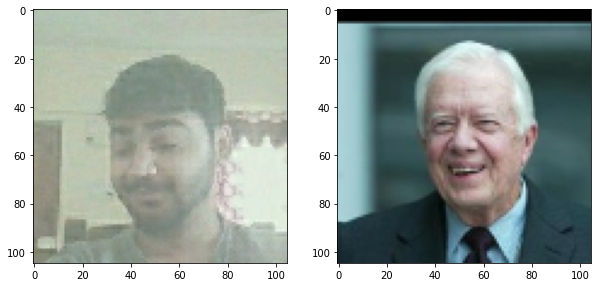

In [68]:
# Visualize results
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[5])
plt.show

## SAVE MODEL

In [70]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [71]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                      custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [72]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


array([[9.9986827e-01],
       [4.2571730e-05],
       [7.8796214e-01],
       [9.0444696e-01],
       [2.1708611e-04],
       [3.8897598e-04],
       [4.3668901e-05],
       [9.9989229e-01],
       [9.9999946e-01],
       [9.8566490e-01],
       [2.4130894e-04],
       [9.9966723e-01],
       [2.1138633e-04],
       [1.0939604e-05],
       [9.9989343e-01],
       [1.8895128e-04]], dtype=float32)

In [73]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# REAL TIME TEST

In [74]:
os.listdir(os.path.join('application_data', 'verification_images'))

['3a0e6369-e3d8-11ec-9411-f47b09d8627d.jpg',
 '3a2389d5-e3d8-11ec-8199-f47b09d8627d.jpg',
 '3a319d57-e3d8-11ec-80df-f47b09d8627d.jpg',
 '3a4004d1-e3d8-11ec-90a8-f47b09d8627d.jpg',
 '3a5c7d4c-e3d8-11ec-8865-f47b09d8627d.jpg',
 '3a6b1010-e3d8-11ec-95b7-f47b09d8627d.jpg',
 '3a795d96-e3d8-11ec-8afc-f47b09d8627d.jpg',
 '3a9a6e81-e3d8-11ec-8625-f47b09d8627d.jpg',
 '3a9f6036-e3d8-11ec-bfe8-f47b09d8627d.jpg',
 '3ab4d86a-e3d8-11ec-949f-f47b09d8627d.jpg',
 '3ab973b8-e3d8-11ec-951e-f47b09d8627d.jpg',
 '3ad102ab-e3d8-11ec-b5af-f47b09d8627d.jpg',
 '3adf7066-e3d8-11ec-bee2-f47b09d8627d.jpg',
 '3b13b278-e3d8-11ec-92b5-f47b09d8627d.jpg',
 '3b6f84ff-e3d8-11ec-ad7c-f47b09d8627d.jpg',
 '3b7ded79-e3d8-11ec-a1a3-f47b09d8627d.jpg',
 '40a51c20-e3d8-11ec-ab91-f47b09d8627d.jpg',
 '42fa9b27-e3d8-11ec-8934-f47b09d8627d.jpg',
 '43a2dfa0-e3d8-11ec-9e42-f47b09d8627d.jpg',
 '50eb153d-e3d8-11ec-bda5-f47b09d8627d.jpg',
 '5e5183a5-e3d8-11ec-908e-f47b09d8627d.jpg',
 '5ec3b52e-e3d8-11ec-bcbc-f47b09d8627d.jpg',
 '5ecd1bfc

In [75]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [76]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\3a0e6369-e3d8-11ec-9411-f47b09d8627d.jpg
application_data\verification_images\3a2389d5-e3d8-11ec-8199-f47b09d8627d.jpg
application_data\verification_images\3a319d57-e3d8-11ec-80df-f47b09d8627d.jpg
application_data\verification_images\3a4004d1-e3d8-11ec-90a8-f47b09d8627d.jpg
application_data\verification_images\3a5c7d4c-e3d8-11ec-8865-f47b09d8627d.jpg
application_data\verification_images\3a6b1010-e3d8-11ec-95b7-f47b09d8627d.jpg
application_data\verification_images\3a795d96-e3d8-11ec-8afc-f47b09d8627d.jpg
application_data\verification_images\3a9a6e81-e3d8-11ec-8625-f47b09d8627d.jpg
application_data\verification_images\3a9f6036-e3d8-11ec-bfe8-f47b09d8627d.jpg
application_data\verification_images\3ab4d86a-e3d8-11ec-949f-f47b09d8627d.jpg
application_data\verification_images\3ab973b8-e3d8-11ec-951e-f47b09d8627d.jpg
application_data\verification_images\3ad102ab-e3d8-11ec-b5af-f47b09d8627d.jpg
application_data\verification_images\3adf7066-e3d8-11ec-bee2-f47

In [77]:
# Verification Function
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
    
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions/ total positive samples
    verification = detection/len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified 

In [78]:
# OpenCV Real Time Verification
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 352ms/step
True


In [79]:
np.sum(np.squeeze(results) > 0.9)

25

In [80]:
results

[array([[0.99979955]], dtype=float32),
 array([[0.999782]], dtype=float32),
 array([[0.9996551]], dtype=float32),
 array([[0.9998511]], dtype=float32),
 array([[0.99966484]], dtype=float32),
 array([[0.99951124]], dtype=float32),
 array([[0.9994124]], dtype=float32),
 array([[0.99969393]], dtype=float32),
 array([[0.99973154]], dtype=float32),
 array([[0.99938947]], dtype=float32),
 array([[0.99938947]], dtype=float32),
 array([[0.99860466]], dtype=float32),
 array([[0.9995647]], dtype=float32),
 array([[0.99997926]], dtype=float32),
 array([[0.99999267]], dtype=float32),
 array([[0.9998725]], dtype=float32),
 array([[0.9999912]], dtype=float32),
 array([[0.9919734]], dtype=float32),
 array([[0.9796058]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.9999984]], dtype=float32),
 array([[0.952132]], dtype=float32),
 array([[0.93302554]], dtype=float32),
 array([[0.93925387]], dtype=float32),
 array([[0.99997693]], dtype=float32)]